### Imports

In [1]:
import numpy as np
import pandas as pd
from glob import glob
from os.path import basename, dirname, isdir, isfile, join
from tqdm import tqdm_notebook as tqdm

### Setup

In [ ]:
root = "/Volumes/hd_4tb/results/training/*/*"
dfs = list()
for folder in tqdm(glob(root)):
    df = pd.read_csv(join(folder, "simple.csv"))
    df["pred"] = np.load(join(folder, "pred.npy"))
    dfs.append(df)
    
print("Combining dataframes...")
df = pd.concat(dfs)

In [ ]:
df.to_feather("/Volumes/hd_4tb/results/summary/simple_all.feather")

### Split data

In [17]:
from sklearn.model_selection import train_test_split

train_x, test_x = train_test_split(df)
train_y = train_x.pop("pred")
test_y = test_x.pop("pred")

### Training

In [25]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# model = xgb.XGBRegressor()
# model = lgb.LGBMRegressor(max_depth=7)
model = RandomForestRegressor()
# model = LinearRegression()
model.fit(train_x, train_y)

/Users/pbezuhov/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### Score

0.2757438381555247


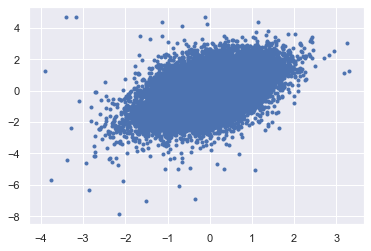

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

score = model.score(test_x, test_y)
expected = model.predict(test_x)
print(score)
plt.plot(expected, test_y, ".");